In [2]:
from pathlib import Path
import traceback
import pandas as pd
import numpy as np
import re
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
current_path = Path.cwd()
processed_folder = current_path/"merged"
concat_reps_tsv = list(processed_folder.glob("*.tsv"))
input_dir = current_path/"calculations"

def concat_reps(suffix, tsv_list, subfolder, processed_folder):
   """
   1. Search TSVs for matching suffix in filename
   2. Put them in list & read them in as pandas dfs
   3. For each dataframe, rename dynamically renamed
      "TotalCoverage" and "DeletionRate" columns to
      generic name
   4. Iteratively concatenate dfs w/ helper function
   5. Drop excess rows
   """
   matches = [tsv for tsv in tsv_list if re.search(suffix, tsv.stem)]
   df_list = [pd.read_csv(str(file), sep = "\t") for file in matches]
   selected_cols = (df_list[0].columns.tolist())[0:17]

   concat_list = []
   pattern_list = ["_TotalCoverage_", "_DeletionRate_"]

   for df in df_list:
      nested_list = []
      new_names = []
      
      for pattern in pattern_list:
         ## New names: TotalCoverage, DeletionRate
         new_names.append(pattern.strip("_"))

         ## Add columns that match pattern to nested_list
         ## (only if match is non-empty)
         match = [col for col in df.columns if re.search(pattern, col)]
         if match:
            nested_list.append(match)

      ## Flatten list of lists into single list
      col_list = list(chain.from_iterable(nested_list))
      
      ## Rename columns specified by value in dictionary
      name_dict = dict(zip(col_list, new_names))
      df = df.rename(columns = name_dict)  
      concat_list.append(df)
   
   df_concat = pd.concat(concat_list, ignore_index = True)
   
   """
   NOTES:
   * Before each merge, drop all columns that are not:
      1. selected_cols
      2. TotalCoverage
      3. DeletionRate
   """
   keep_list = list([col for col in df_concat.columns 
                     if re.search("(TotalCoverage|DeletionRate)", col)]) + selected_cols
   diff_cols = (df_concat.columns.difference(keep_list, sort = False))
   df_final = df_concat.drop(columns = diff_cols)

   """
   Save merged dataframe as TSV
   """
   merged_dir = processed_folder/f"{subfolder.name}{suffix}.tsv"
   df_final.to_csv(merged_dir, sep = "\t", index = False)

for subfolder in input_dir.iterdir():
    tsv_folder = input_dir/subfolder/"individual_tsv"

    if subfolder.is_dir():
    ## Collect paths of .tsv files and put in list
        tsv_list = sorted(
            tsv_folder.glob("*.tsv"),
            key = lambda x: int(re.search(r"Rep(\d+)", x.name).group(1)) ## order by rep integer
        )
    ## Merge replicates for each sample type
    for suffix in ["-BS", "-NBS"]:
        concat_reps(suffix, tsv_list, subfolder, processed_folder)

concat_reps_tsv = list(processed_folder.glob("*.tsv"))

## Create concat dataframe of all files in rep_dir
df_list = [pd.read_csv(str(file), sep = "\t") for file in concat_reps_tsv]
total_cov = pd.concat(df_list, ignore_index = True)

## Separately, create 3 additonal concat dataframes based on pattern
df_name = {}
file_pattern = ["7KO.*-BS", "7KO.*-NBS"]
var_names = ["7ko_bs_dr", "7ko_nbs_dr"] 

for pattern, name in zip(file_pattern, var_names):
    matches = [tsv for tsv in concat_reps_tsv if re.search(pattern, tsv.stem)]
    match_list = [pd.read_csv(str(file), sep = "\t") for file in matches]
    df_name[name] = pd.concat(match_list, ignore_index = True)

In [4]:
class GraphPlots:
   def del_rate(self, df, graph_folder, df_name, counter):
      col = "DeletionRate"

      ## Prepare unique part of filename
      """
      EXAMPLE:
      7ko_bs_dr -> "7KO-BS"
      """
      key = str(next(key for key, val in df_name.items() if val.equals(df)))
      sample_group = "-".join(key.split("_")[0:2]).upper()
      df_drop = df[df[col] != 0].copy()

      ## Create histogram of non-zero DeletionRate
      hist_fig = sns.displot(data = df_drop, x = col,
                  kde = True, edgecolor = "white",
                  height = 6.5, aspect = 10/6.5)
      counter += 1
      plt.title(f"Figure {counter}: Histogram of all non-zero {col} in {sample_group}")
      hist_fig.savefig(graph_folder/f"Fig{counter}_{sample_group}_{col}_Histogram.png", 
                       format = "png", dpi = 300)
      plt.close()

      ## Create ECDF and plot median
      ecdf_fig = plt.figure(figsize = (10, 6.5))
      sns.ecdfplot(df_drop[col])
      median = df_drop[col].median()
      plt.axvline(x = median, color = "red", ls = ":", lw = 1.5, alpha = 0.3)
      plt.axhline(y = 0.5, color = "red", ls = ":", lw = 1.5, alpha = 0.3)
      plt.text(median, 0.5, f"Median: {round(median, 4)}", 
               horizontalalignment = "right",
               verticalalignment = "bottom",
               bbox = {
                  "facecolor": "white",
                  "edgecolor": "black",
                  "boxstyle": "square, pad = 0.5"
               })
      counter += 1
      plt.title(f"Figure {counter}: ECDF of all non-zero {col} in {sample_group}")
      ecdf_fig.savefig(graph_folder/f"Fig{counter}_{sample_group}_{col}_ECDF.png", 
                       format = "png", dpi = 300)
      plt.close()

      return counter

   def total_cov(self, df, graph_folder, counter):
      col = "TotalCoverage"
      
      ## Create histogram
      hist_fig = sns.displot(data = df, x = col, 
                             kde = True, edgecolor = "white", 
                             height = 6.5, aspect = 10/6.5)
      plt.title(f"Figure {counter}: Histogram of all {col}")
      plt.xlim(0, 200) ## I've set an arbitrary limit here, since we don't expect a lot of TotalCov > 200
      hist_fig.savefig(graph_folder/f"Fig{counter}_{col}_Histogram.png", format = "png", dpi = 300)
      plt.close()

      ## Create ECDF and plot median
      ecdf_fig = plt.figure(figsize = (10, 6.5))
      sns.ecdfplot(df[col])
      median = df[col].median()
      plt.axvline(x = median, color = "red", ls = ":", lw = 1.5, alpha = 0.3)
      plt.axhline(y = 0.5, color = "red", ls = ":", lw = 1.5, alpha = 0.3)
      plt.text(median, 0.5, s = f"Median: {median}",
               horizontalalignment = "right",
               verticalalignment = "bottom",
               bbox = {
                  "facecolor": "white",
                  "edgecolor": "black",
                  "boxstyle": "square, pad = 0.5"
               })
      counter += 1
      plt.title(f"Figure {counter}: ECDF of all {col}")
      plt.xlim(0, 200) ## Same arbitrary limit as before
      ecdf_fig.savefig(graph_folder/f"Fig{counter}_{col}_ECDF.png", format = "png", dpi = 300)
      plt.close()

      return counter

   def graph_all(self, counter, df, graph_folder, df_name):
      try: 
         if counter == 1:
            ## Graph distributions for TotalCoverage & update count
            counter = self.total_cov(df, graph_folder, counter)

         else:
            ## Graph distributions for DeletionRate & update count
            counter = self.del_rate(df, graph_folder, df_name, counter)
            
         return counter
      except Exception as e:
         print(f"Failed to create distribution graphs: {e}")
         traceback.print_exc()
         raise

In [5]:
graph = GraphPlots()

graph_folder = current_path/"distributions"
graph_folder.mkdir(exist_ok = True, parents = True)

## Dataframes that we want to make graphs for
df_graphs = [total_cov, df_name["7ko_bs_dr"]]

## Run graph_plots function
sns.set_palette(palette = "plasma_r")
plt.rcParams["font.family"] = "Cambria"
counter = 1

for df in df_graphs:
      counter = graph.graph_all(counter, df, graph_folder, df_name)

In [6]:
current_path = Path.cwd()
processed_folder = current_path/"merged"
random_folder = current_path/"random"
if not any(Path(processed_folder).iterdir()):
    print("Empty")
else:
    print("Not empty")

Not empty


### Test code

In [7]:
current_path = Path.cwd()
processed_folder = current_path/"merged"
concat_reps_tsv = list(processed_folder.glob("*.tsv"))
input_dir = current_path/"calculations"

In [8]:
def concat_reps(suffix, tsv_list, subfolder, processed_folder):
   """
   1. Search TSVs for matching suffix in filename
   2. Put them in list & read them in as pandas dfs
   3. For each dataframe, rename dynamically renamed
      "TotalCoverage" and "DeletionRate" columns to
      generic name
   4. Iteratively concatenate dfs w/ helper function
   5. Drop excess rows
   """
   matches = [tsv for tsv in tsv_list if re.search(suffix, tsv.stem)]
   df_list = [pd.read_csv(str(file), sep = "\t") for file in matches]
   selected_cols = (df_list[0].columns.tolist())[0:17]

   concat_list = []
   pattern_list = ["_TotalCoverage_", "_DeletionRate_"]

   for df in df_list:
      nested_list = []
      new_names = []
      
      for pattern in pattern_list:
         ## New names: TotalCoverage, DeletionRate
         new_names.append(pattern.strip("_"))

         ## Add columns that match pattern to nested_list
         ## (only if match is non-empty)
         match = [col for col in df.columns if re.search(pattern, col)]
         if match:
            nested_list.append(match)

      ## Flatten list of lists into single list
      col_list = list(chain.from_iterable(nested_list))
      
      ## Rename columns specified by value in dictionary
      name_dict = dict(zip(col_list, new_names))
      df = df.rename(columns = name_dict)  
      concat_list.append(df)
   
   df_concat = pd.concat(concat_list, ignore_index = True)
   
   """
   NOTES:
   * Before each merge, drop all columns that are not:
      1. selected_cols
      2. TotalCoverage
      3. DeletionRate
   """
   keep_list = list([col for col in df_concat.columns 
                     if re.search("(TotalCoverage|DeletionRate)", col)]) + selected_cols
   diff_cols = (df_concat.columns.difference(keep_list, sort = False))
   df_final = df_concat.drop(columns = diff_cols)

   """
   Save merged dataframe as TSV
   """
   merged_dir = processed_folder/f"{subfolder.name}{suffix}.tsv"
   df_final.to_csv(merged_dir, sep = "\t", index = False)

In [9]:
for subfolder in input_dir.iterdir():
    tsv_folder = input_dir/subfolder/"individual_tsv"

    if subfolder.is_dir():
    ## Collect paths of .tsv files and put in list
        tsv_list = sorted(
            tsv_folder.glob("*.tsv"),
            key = lambda x: int(re.search(r"Rep(\d+)", x.name).group(1)) ## order by rep integer
        )
    ## Merge replicates for each sample type
    for suffix in ["-BS", "-NBS"]:
        concat_reps(suffix, tsv_list, subfolder, processed_folder)

In [10]:
concat_reps_tsv = list(processed_folder.glob("*.tsv"))

## Create concat dataframe of all files in rep_dir
df_list = [pd.read_csv(str(file), sep = "\t") for file in concat_reps_tsv]
total_cov = pd.concat(df_list, ignore_index = True)

## Separately, create 3 additonal concat dataframes based on pattern
df_name = {}
file_pattern = ["7KO.*-BS", "7KO.*-NBS"]
var_names = ["7ko_bs_dr", "7ko_nbs_dr"] 

for pattern, name in zip(file_pattern, var_names):
    matches = [tsv for tsv in concat_reps_tsv if re.search(pattern, tsv.stem)]
    match_list = [pd.read_csv(str(file), sep = "\t") for file in matches]
    df_name[name] = pd.concat(match_list, ignore_index = True)

In [11]:
len(total_cov)
plt.rcParams["font.family"] = "Cambria"
col = "DeletionRate"
counter = 1

Text(0.5, 1.0, 'Figure 29: Histogram of all DeletionRate in 7KO-BS')

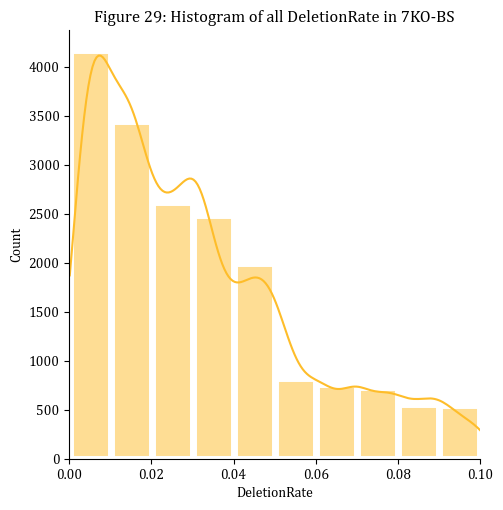

In [75]:
#### TESTING PART

df = df_name["7ko_bs_dr"]
col = "DeletionRate"

key = str(next(key for key, val in df_name.items() if val.equals(df)))
sample_group = "-".join(key.split("_")[0:2]).upper()

df_drop = df[df[col] != 0].copy()
hist_fig = sns.displot(data = df_drop, x = col,
                       kde = True, edgecolor = "white", binwidth = 0.01, linewidth = 5)
plt.xlim(0, 0.1)
plt.ticklabel_format(axis = "y", style = "plain")

counter += 1
plt.title(f"Figure {counter}: Histogram of all {col} in {sample_group}")

Text(0.5, 1.0, 'Figure 2: ECDF of all DeletionRate in 7KO-BS')

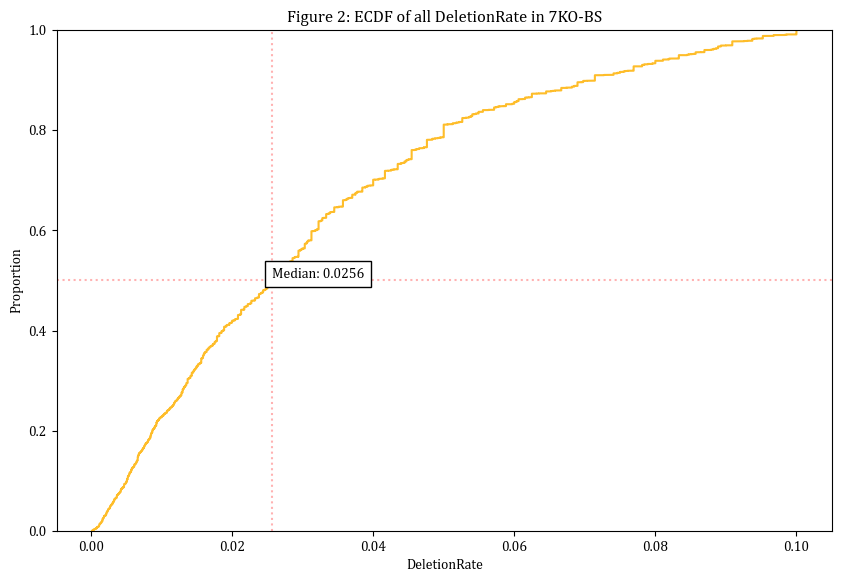

In [13]:
## Create ECDF and plot median
ecdf_fig = plt.figure(figsize = (10, 6.5))
sns.ecdfplot(df_drop[col])
median = df_drop[col].median()
plt.axvline(x = median, color = "red", ls = ":", lw = 1.5, alpha = 0.3)
plt.axhline(y = 0.5, color = "red", ls = ":", lw = 1.5, alpha = 0.3)
plt.text(median, 0.5, f"Median: {round(median, 4)}", 
         horizontalalignment = "left", 
         verticalalignment = "bottom",
         bbox = {
             "facecolor": "white",
             "edgecolor": "black",
             "boxstyle": "square, pad = 0.5"
         })

plt.title(f"Figure {counter}: ECDF of all {col} in {sample_group}")

### OLD (Timing functions)

In [14]:
"""
OBJECTIVE:
Investigate if it's better to directly concatenate dataframes, or to merge dataframes first
and select out columns and convert them to a series with pd.concat
"""

"\nOBJECTIVE:\nInvestigate if it's better to directly concatenate dataframes, or to merge dataframes first\nand select out columns and convert them to a series with pd.concat\n"

In [15]:
df1_list = [{"Chrom": "NW233434", 
                "GenomicModBase": 231, 
                "Rep1_A_BS": 4, 
                "Rep1_C_BS": 1, 
                "Rep1_G_BS": 1, 
                "Rep1_T_BS": 1, 
                "Rep1_TotalCoverage_BS": 2,
                "Rep1_DeletionRate_BS": 0.87}, 

                {"Chrom": "NW233438", 
                "GenomicModBase": 231, 
                "Rep1_A_BS": 4, 
                "Rep1_C_BS": 1, 
                "Rep1_G_BS": 1, 
                "Rep1_T_BS": 1, 
                "Rep1_TotalCoverage_BS": 5,
                "Rep1_DeletionRate_BS": 0.67},

                {"Chrom": "NW233435", 
                 "GenomicModBase": 331, 
                 "Rep1_A_BS": None, 
                 "Rep1_C_BS": None, 
                 "Rep1_G_BS": None, 
                 "Rep1_T_BS": None, 
                 "Rep1_TotalCoverage_BS": 3,
                 "Rep1_DeletionRate_BS": 0.4},

                {"Chrom": "NW233433", 
                "GenomicModBase": 230, 
                "Rep1_A_BS": 3, 
                "Rep1_C_BS": 1, 
                "Rep1_G_BS": 1, 
                "Rep1_T_BS": 1, 
                "Rep1_TotalCoverage_BS": 0,
                "Rep1_DeletionRate_BS": 0.2},
                
                {"Chrom": "NW233432", 
                "GenomicModBase": 229, 
                "Rep1_A_BS": 2, 
                "Rep1_C_BS": 6, 
                "Rep1_G_BS": 4, 
                "Rep1_T_BS": 7, 
                "Rep1_TotalCoverage_BS": 0,
                "Rep1_DeletionRate_BS": 0.93}]
df1 = pd.DataFrame(df1_list).drop_duplicates()

In [16]:
df2_list = [{"Chrom": "NW233434", 
            "GenomicModBase": 231, 
            "Rep2_A_BS": 4, 
            "Rep2_C_BS": 1, 
            "Rep2_G_BS": 1, 
            "Rep2_T_BS": 1, 
            "Rep2_TotalCoverage_BS": 77,
            "Rep2_DeletionRate_BS": 0.56}, 

            {"Chrom": "NW233438", 
             "GenomicModBase": 231, 
             "Rep2_A_BS": 4, 
             "Rep2_C_BS": 1, 
             "Rep2_G_BS": 1, 
             "Rep2_T_BS": 1, 
             "Rep2_TotalCoverage_BS": 88,
             "Rep2_DeletionRate_BS": 0.76},

            {"Chrom": "NW233435", 
             "GenomicModBase": 331, 
             "Rep2_A_BS": None, 
             "Rep2_C_BS": None, 
             "Rep2_G_BS": None, 
             "Rep2_T_BS": None, 
             "Rep2_TotalCoverage_BS": 99,
             "Rep2_DeletionRate_BS": 0.86},

            {"Chrom": "NW233433", 
             "GenomicModBase": 230, 
             "Rep2_A_BS": 3, 
             "Rep2_C_BS": 1, 
             "Rep2_G_BS": 1, 
             "Rep2_T_BS": 1, 
             "Rep2_TotalCoverage_BS": 100,
             "Rep2_DeletionRate_BS": 0.23},
            
            {"Chrom": "NW233432", 
             "GenomicModBase": 229, 
             "Rep2_A_BS": 2, 
             "Rep2_C_BS": 6, 
             "Rep2_G_BS": 4, 
             "Rep2_T_BS": 7, 
             "Rep2_TotalCoverage_BS": 40,
             "Rep2_DeletionRate_BS": 0.10}]
df2 = pd.DataFrame(df2_list).drop_duplicates()

In [17]:
df_list = [df1, df2]

In [18]:
%%timeit
def manual_concat(df_list):
    new_list = []
    for df in df_list:
        cov_col = [col for col in df.columns if re.search("_TotalCoverage_", col)]
        if cov_col:
            diff_cols = (df.columns.difference(cov_col, sort = False))
            df = df.drop(columns = diff_cols).rename(columns = {cov_col[0]: "TotalCoverage"})
            new_list.append(df)
    
    df_concat = pd.concat(new_list, ignore_index = True)
    return df_concat

manual_concat(df_list)

2.46 ms ± 704 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit

def merge_first(df1, df2):
    selected_cols = (df1.columns.tolist())[0:2]
    df_merged = pd.merge(df1, df2,
                         on = selected_cols,
                         how = "outer",
                         sort = False)
    cov_col = [col for col in df_merged.columns if re.search("_TotalCoverage_", col)]
    series_list = [df_merged[col] for col in cov_col]
    single_series = pd.concat(series_list, ignore_index = True)
    return single_series

merge_first(df1, df2)

3.38 ms ± 432 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### OLD (Testing pre-processing function)

In [20]:
name_dict = {"Rep1_TotalCoverage_BS": "TotalCoverage",
             "Rep1_DeletionRate_BS": "DeletionRate"}

df1 = df1.rename(columns = name_dict)

In [21]:
def drop_cols(df, colnames, selected_cols):
    """
    NOTES:
    * Before each merge, drop all columns that are not:
        1. selected_cols
        2. TotalCoverage
        3. DeletionRate
    """
    keep_list = list([col for col in colnames 
                    if re.search("(TotalCoverage|DeletionRate)", col)]) + selected_cols
    diff_cols = (df.columns.difference(keep_list, sort = False))
    df = df.drop(columns = diff_cols)
    return df


In [22]:
selected_cols = (df1.columns.tolist())[0:2]
random = drop_cols(df1, df1.columns, selected_cols)

In [23]:
from itertools import chain

selected_cols = (df1.columns.tolist())[0:2]

def iter_concat(df_list, pattern_list, selected_cols):
    processed_list = []
    nested_list = []
    new_names = []

    for df in df_list:
        for pattern in pattern_list:
            new_names.append(pattern.strip("_"))
            match = [col for col in df.columns if re.search(pattern, col)]
            if match:
                nested_list.append(match)

        col_list = list(chain.from_iterable(nested_list))
        
        name_dict = dict(zip(col_list, new_names))
        df = df.rename(columns = name_dict)  
        processed_list.append(df)
    
    df_concat = pd.concat(processed_list, ignore_index = True)
    df_final = drop_cols(df_concat, df_concat.columns, selected_cols)
    
    return df_final

pattern_list = ["_TotalCoverage_", "_DeletionRate_"]
new_data = iter_concat(df_list, pattern_list, selected_cols)

Text(0.5, 1.0, 'Table 2: ECDF of all TotalCoverage')

<Figure size 1000x650 with 0 Axes>

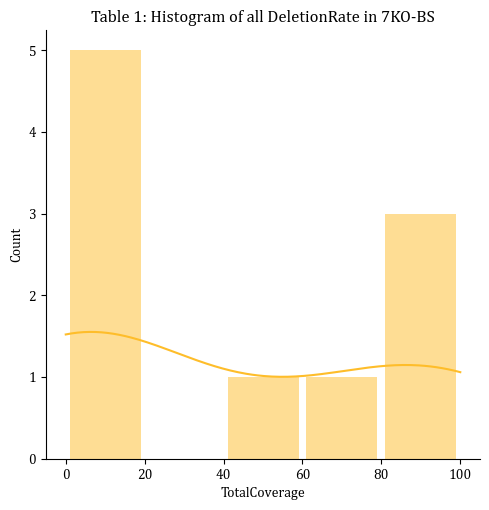

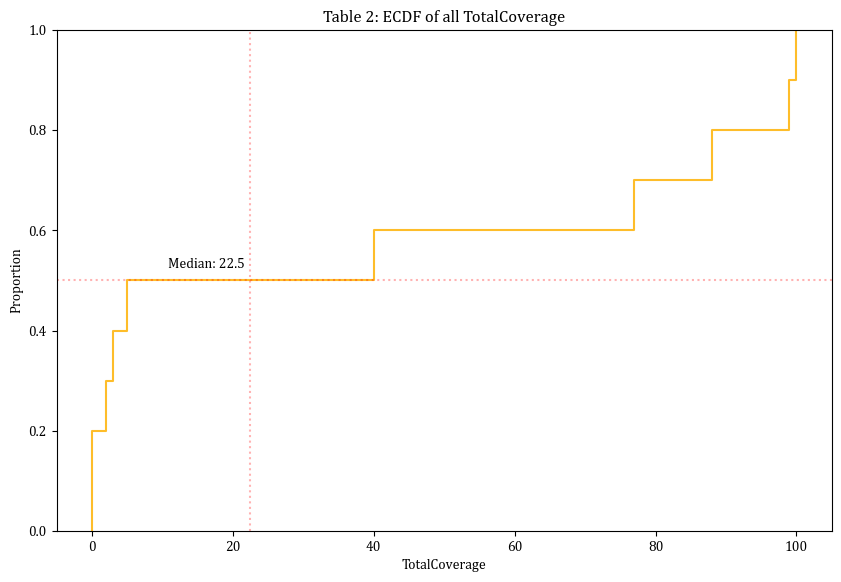

In [38]:

hist_fig = plt.figure(figsize = (10, 6.5))
sns.displot(data = new_data, x = "TotalCoverage", kde = True, edgecolor = None, shrink = 0.90)
plt.title("Table 1: Histogram of all DeletionRate in 7KO-BS")

ecdf_fig = plt.figure(figsize = (10, 6.5))
sns.ecdfplot(new_data["TotalCoverage"])
median = new_data["TotalCoverage"].median()
plt.axvline(x = median, color = "red", ls = ":", lw = 1.5, alpha = 0.3)
plt.axhline(y = 0.5, color = "red", ls = ":", lw = 1.5, alpha = 0.3)
plt.text(median, 0.52, f"Median: {median:<6}", horizontalalignment = "right", verticalalignment = "bottom")
plt.title("Table 2: ECDF of all TotalCoverage")

# ecdf_fig.savefig(path, format = "png", dpi = 300)
# hist_fig.savefig(path, format = "png", dpi = 300)
# plt.close()

In [25]:
words = "7KO.*BS"
re.sub(r"\.\*", "-", words)

'7KO-BS'

In [26]:
key = "wt_bs_dr"

sample_group = "-".join(key.split("_")[0:2]).upper()

sample_group

'WT-BS'